Visualization of normalized snRNA-seq data

INFO: Run with conda environment sc-mar2021
--> sc-arches (newer scanpy version) for part below (e.g. metrics function)

# 0. Load packages

<a id='load_packages'></a>

In [ ]:
import os
import sys
import glob
import re

import anndata
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb

In [ ]:
plt.rcParams['figure.figsize']=(20,12) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

In [ ]:
sys.path.insert(0,'..')
import paths_downsampling as paths
p = paths.get_paths()
print(p)

# 1. Visualization

In [4]:
adata = sc.read(p['writedir']+'adata_normlog_RNA_downsampling_perCell_filtDoublets.h5ad')

In [5]:
# Inspect adata object
print(adata)
#print(adata.var['highly_variable_sct_residual_var'])
#print(adata.layers['sct_corrected'])
#print(adata.X)

AnnData object with n_obs × n_vars = 850720 × 26182
    obs: 'sample', 'individual', 'region', 'experiment', 'batch', 'SU.Number', 'Age', 'AgeBin', 'Sex', 'Ethnic.origin', 'Status', 'Classification', 'Classification.detail', 'Trauma.Code', 'Trauma.notes.medical.history', 'PMI', 'Hemisphere', 'Brain.pH', 'RIN', 'Chlorpromazine.equivalent', 'Antidepressants', 'Mode.of.death', 'Manner.of.Death', 'Suicide', 'COD.category', 'positive.Toxicology', 'Antipsychotics', 'Duration.of.psych.illness', 'Antipsychotics.meds.pres', 'Smoking.status', 'Freezer.storage.time..days.', 'alcohol.intake..g.day.past.12.mth.', 'Age.of.onset', 'Agonal.score', 'Main.Batch', '6-Batch', 'Position', 'Group', 'Operator', 'aaa', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_gene

In [6]:
# remove things that will be recalculated here on normalized data
adata.var.drop(['highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_sct_residual_var'], 
               axis = 1, inplace = True)
del adata.obsp['connectivities']
del adata.obsp['distances']
del adata.uns['hvg']
del adata.uns['neighbors']
del adata.uns['pca']
del adata.uns['umap']
del adata.obsm['X_pca']
del adata.obsm['X_umap']
del adata.varm['PCs']

In [7]:
adata

AnnData object with n_obs × n_vars = 850720 × 26182
    obs: 'sample', 'individual', 'region', 'experiment', 'batch', 'SU.Number', 'Age', 'AgeBin', 'Sex', 'Ethnic.origin', 'Status', 'Classification', 'Classification.detail', 'Trauma.Code', 'Trauma.notes.medical.history', 'PMI', 'Hemisphere', 'Brain.pH', 'RIN', 'Chlorpromazine.equivalent', 'Antidepressants', 'Mode.of.death', 'Manner.of.Death', 'Suicide', 'COD.category', 'positive.Toxicology', 'Antipsychotics', 'Duration.of.psych.illness', 'Antipsychotics.meds.pres', 'Smoking.status', 'Freezer.storage.time..days.', 'alcohol.intake..g.day.past.12.mth.', 'Age.of.onset', 'Agonal.score', 'Main.Batch', '6-Batch', 'Position', 'Group', 'Operator', 'aaa', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_gene

In [8]:
# Filter out samples that don't seem to be representative
adata = adata[adata.obs['individual'] != 281]
adata = adata[adata.obs['individual'] != 381]
adata = adata[adata.obs['individual'] != 335]
adata = adata[adata.obs['individual'] != 498]
adata

View of AnnData object with n_obs × n_vars = 812585 × 26182
    obs: 'sample', 'individual', 'region', 'experiment', 'batch', 'SU.Number', 'Age', 'AgeBin', 'Sex', 'Ethnic.origin', 'Status', 'Classification', 'Classification.detail', 'Trauma.Code', 'Trauma.notes.medical.history', 'PMI', 'Hemisphere', 'Brain.pH', 'RIN', 'Chlorpromazine.equivalent', 'Antidepressants', 'Mode.of.death', 'Manner.of.Death', 'Suicide', 'COD.category', 'positive.Toxicology', 'Antipsychotics', 'Duration.of.psych.illness', 'Antipsychotics.meds.pres', 'Smoking.status', 'Freezer.storage.time..days.', 'alcohol.intake..g.day.past.12.mth.', 'Age.of.onset', 'Agonal.score', 'Main.Batch', '6-Batch', 'Position', 'Group', 'Operator', 'aaa', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'n_counts',

In [9]:
# Store raw count in another layer and corrected counts in main layer adata.X
# change this so that adata.X is getting log-transformed and adata.layers['sct_corrected'] are residuals
adata.layers['counts'] = adata.X
adata.X = adata.layers['sct_corrected'].copy()
#del adata.layers['sct_corrected']

In [10]:
# log transform sct-corrected data in "sct_corrected" layer
sc.pp.log1p(adata, layer='sct_corrected')

In [11]:
# identify highly variable genes on log-transformed sct-corrected data
sc.pp.highly_variable_genes(adata, layer='sct_corrected')

extracting highly variable genes
    finished (0:00:46)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [12]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50)     # uses by default highly variable genes if they were determined before, maybe change this as HVGs can be wrong before batch correction
sc.pp.neighbors(adata)           # uses by default PCs for calculation

#sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
#sc.tl.diffmap(adata)
#sc.tl.draw_graph(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:02:07)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:07)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:38:40)


In [13]:
#Write data
adata.write(p['writedir']+'adata_umap_SampleFilt.h5ad')

In [4]:
adata = sc.read(p['writedir']+'adata_umap_SampleFilt.h5ad')

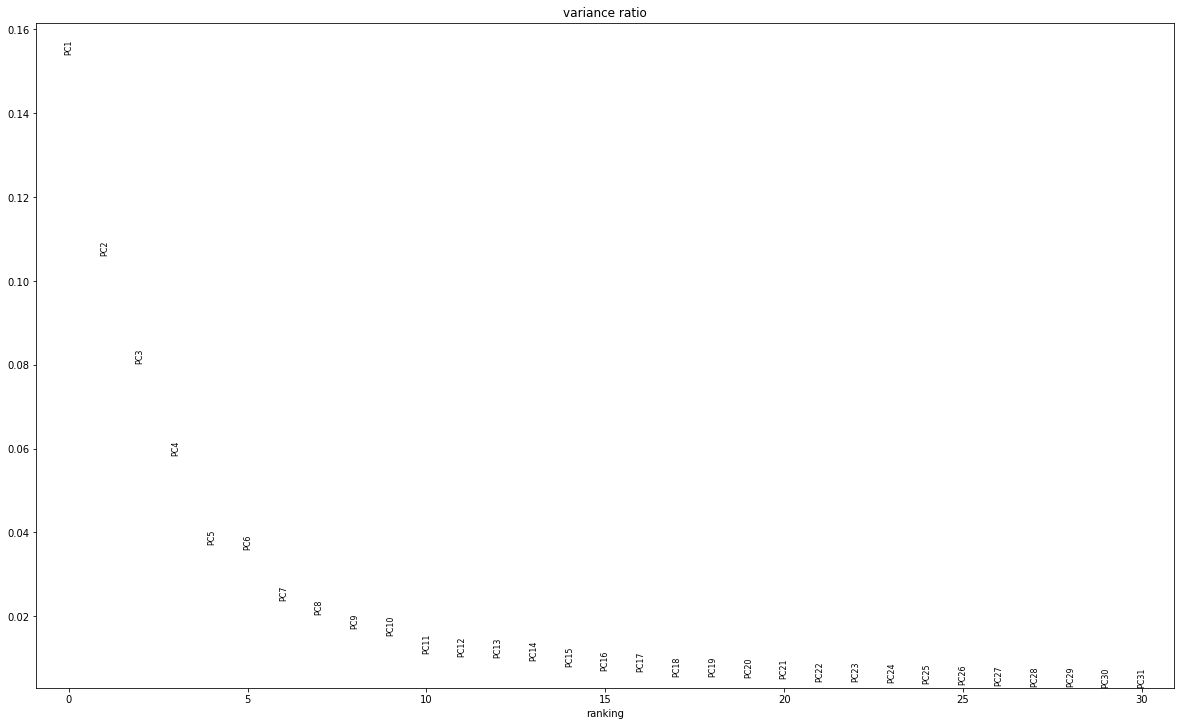

In [5]:
# plot variance loadings of the PCs
sc.pl.pca_variance_ratio(adata)

In [28]:
df_pca = pd.DataFrame({'PC': ["PC"+str(i) for i in range(1,51)],
                       'expl_var': adata.uns['pca']['variance_ratio']})
df_pca['cumsum'] = df_pca['expl_var'].cumsum()
df_pca.head

<bound method NDFrame.head of       PC  expl_var    cumsum
0    PC1  0.153922  0.153922
1    PC2  0.106216  0.260138
2    PC3  0.080319  0.340457
3    PC4  0.058381  0.398838
4    PC5  0.037079  0.435917
5    PC6  0.036077  0.471995
6    PC7  0.023938  0.495933
7    PC8  0.020517  0.516450
8    PC9  0.017089  0.533538
9   PC10  0.015551  0.549089
10  PC11  0.011286  0.560375
11  PC12  0.010351  0.570726
12  PC13  0.010124  0.580850
13  PC14  0.009585  0.590435
14  PC15  0.008187  0.598622
15  PC16  0.007035  0.605657
16  PC17  0.006805  0.612461
17  PC18  0.005731  0.618192
18  PC19  0.005609  0.623801
19  PC20  0.005421  0.629222
20  PC21  0.005221  0.634444
21  PC22  0.004484  0.638928
22  PC23  0.004394  0.643322
23  PC24  0.004162  0.647484
24  PC25  0.003953  0.651437
25  PC26  0.003786  0.655223
26  PC27  0.003545  0.658768
27  PC28  0.003331  0.662099
28  PC29  0.003230  0.665329
29  PC30  0.003161  0.668490
30  PC31  0.003113  0.671604
31  PC32  0.002956  0.674560
32  PC33  0.0

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 [Text(0, 0, 'PC1'),
  Text(1, 0, 'PC2'),
  Text(2, 0, 'PC3'),
  Text(3, 0, 'PC4'),
  Text(4, 0, 'PC5'),
  Text(5, 0, 'PC6'),
  Text(6, 0, 'PC7'),
  Text(7, 0, 'PC8'),
  Text(8, 0, 'PC9'),
  Text(9, 0, 'PC10'),
  Text(10, 0, 'PC11'),
  Text(11, 0, 'PC12'),
  Text(12, 0, 'PC13'),
  Text(13, 0, 'PC14'),
  Text(14, 0, 'PC15'),
  Text(15, 0, 'PC16'),
  Text(16, 0, 'PC17'),
  Text(17, 0, 'PC18'),
  Text(18, 0, 'PC19'),
  Text(19, 0, 'PC20'),
  Text(20, 0, 'PC21'),
  Text(21, 0, 'PC22'),
  Text(22, 0, 'PC23'),
  Text(23, 0, 'PC24'),
  Text(24, 0, 'PC25'),
  Text(25, 0, 'PC26'),
  Text(26, 0, 'PC27'),
  Text(27, 0, 'PC28'),
  Text(28, 0, 'PC29'),
  Text(29, 0, 'PC30'),
  Text(30, 0, 'PC31'),
  Text(31, 0, 'PC32'),
  Text(32, 0, 'PC33'),
  Text(33, 0, 'PC34'),
  Text(34, 

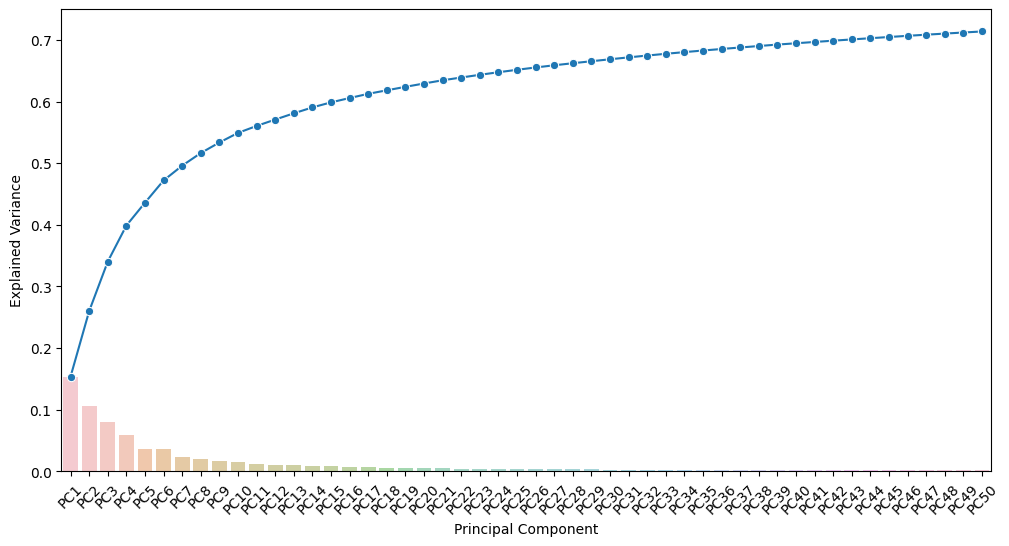

In [30]:
# plot PCA variance explained + cumulative variance explained
matplotlib.rc_file_defaults()
ax1 = sb.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sb.lineplot(data = df_pca['cumsum'][0:19], marker='o', sort = False, ax=ax1)

sb.barplot(data = df_pca['expl_var'], x='PC', y='expl_var', alpha=0.5, ax=ax1)

ax1.set(xlabel='Principal Component', ylabel='Explained Variance')

plt.xticks(rotation=45)

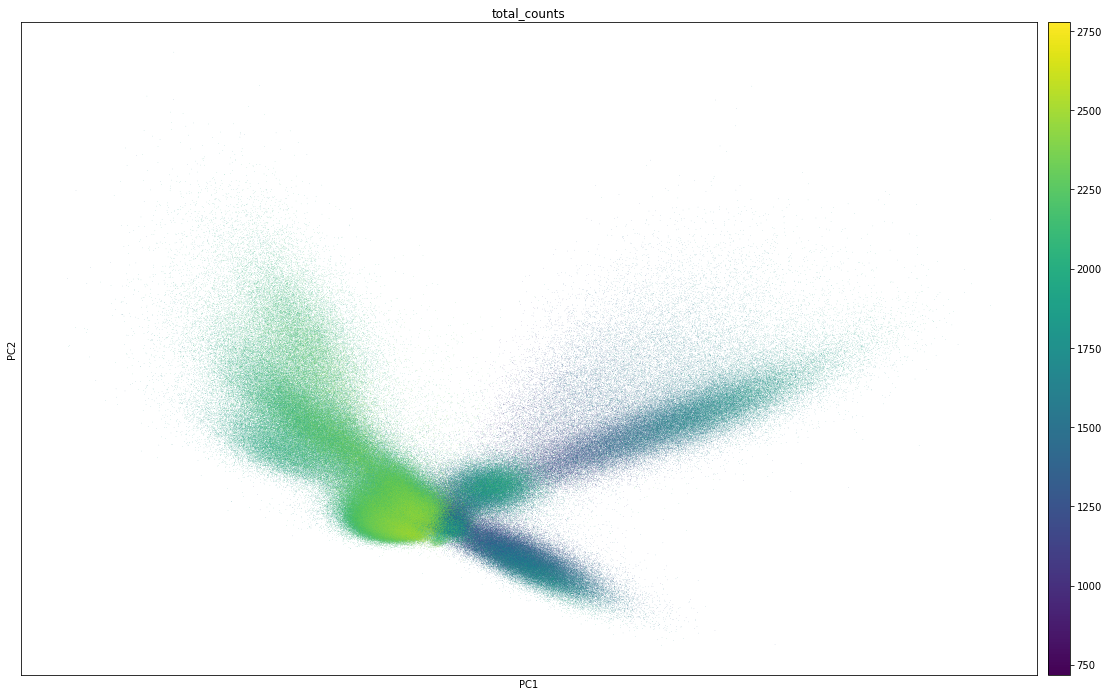

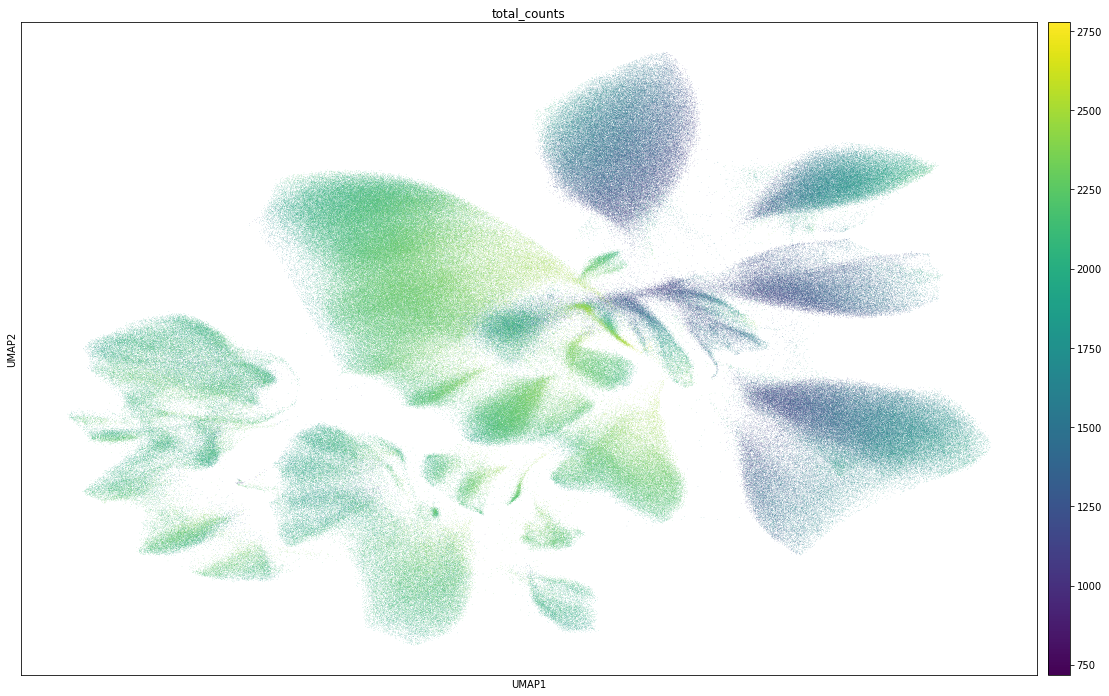

In [6]:
sc.pl.pca_scatter(adata, color='total_counts', size=500000 /adata.n_obs)
sc.pl.umap(adata, color='total_counts', size=500000 /adata.n_obs)

In [7]:
adata
adata.var['highly_variable'].value_counts()

False    23143
True      3039
Name: highly_variable, dtype: int64

In [8]:
# Perform clustering - using highly variable genes
sc.tl.leiden(adata, key_added='leiden_r1', random_state = 10)
#sc.tl.leiden(adata, resolution=0.5, key_added='leiden_r0.5', random_state=10)

running Leiden clustering
    finished: found 30 clusters and added
    'leiden_r1', the cluster labels (adata.obs, categorical) (0:16:56)


In [9]:
# Perform clustering - using highly variable genes
#sc.tl.leiden(adata, key_added='leiden_r1', random_state = 10)
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_r0.5', random_state=10)

running Leiden clustering
    finished: found 22 clusters and added
    'leiden_r0.5', the cluster labels (adata.obs, categorical) (0:11:18)


In [10]:
# Perform clustering - using highly variable genes
sc.tl.leiden(adata, resolution=0.6, key_added='leiden_r0.6', random_state=10)

running Leiden clustering
    finished: found 23 clusters and added
    'leiden_r0.6', the cluster labels (adata.obs, categorical) (0:13:10)


In [11]:
# Perform clustering - using highly variable genes
sc.tl.leiden(adata, resolution=0.8, key_added='leiden_r0.8', random_state=10)

running Leiden clustering
    finished: found 26 clusters and added
    'leiden_r0.8', the cluster labels (adata.obs, categorical) (0:11:18)


In [ ]:
# Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata, color=['leiden_r1'], size=500000 /adata.n_obs)#, palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['leiden_r0.8'], size=500000 /adata.n_obs)#, palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['leiden_r0.6'], size=500000 /adata.n_obs)#, palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['leiden_r0.5'], size=500000 /adata.n_obs)#, palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['total_counts'], size=500000 /adata.n_obs)
sc.pl.umap(adata, color=['sample'], size=500000 /adata.n_obs)
sc.pl.umap(adata, color=['n_genes_by_counts'], size=500000 /adata.n_obs)
sc.pl.umap(adata, color=['pct_counts_mito'], size=500000 /adata.n_obs)

In [ ]:
sc.settings.set_figure_params(dpi=300, frameon=False)
sc.set_figure_params(dpi=300)
sc.set_figure_params(figsize=(12, 10))
sc.pl.umap(adata, color=['leiden_r1', 'sample'], size=500000 /adata.n_obs)#, palette=sc.pl.palettes.default_64)

In [ ]:
# Statistics of data set 
print(adata.obs['region'].value_counts())
print('')
print(adata.obs['sample'].value_counts())

In [15]:
#Write data
adata.write(p['writedir']+'adata_clustering_SampleFilt.h5ad')

In [4]:
adata = sc.read(p['writedir']+'adata_clustering_SampleFilt.h5ad')

In [ ]:
# change type of some metadata 
adata.obs['individual'] = adata.obs['individual'].astype('category')
adata.obs['Operator'] = adata.obs['Operator'].astype('category')
adata.obs['aaa'] = adata.obs['aaa'].astype('category')
adata.obs

## 1.1 Covariate visualization

In [13]:
# column names
#print(adata.obs.dtypes)
adata.obs['Main.Batch'] = adata.obs['Main.Batch'].astype('category')
adata.obs['6-Batch'] = adata.obs['6-Batch'].astype('category')
adata.obs['Position'] = adata.obs['Position'].astype('category')
print(adata.obs.dtypes)

sample                                category
individual                            category
region                                category
experiment                            category
batch                                 category
SU.Number                                int64
Age                                      int64
AgeBin                                category
Sex                                   category
Ethnic.origin                         category
Status                                   int64
Classification                        category
Classification.detail                 category
Trauma.Code                              int64
Trauma.notes.medical.history          category
PMI                                    float64
Hemisphere                            category
Brain.pH                               float64
RIN                                    float64
Chlorpromazine.equivalent             category
Antidepressants                       category
Mode.of.death

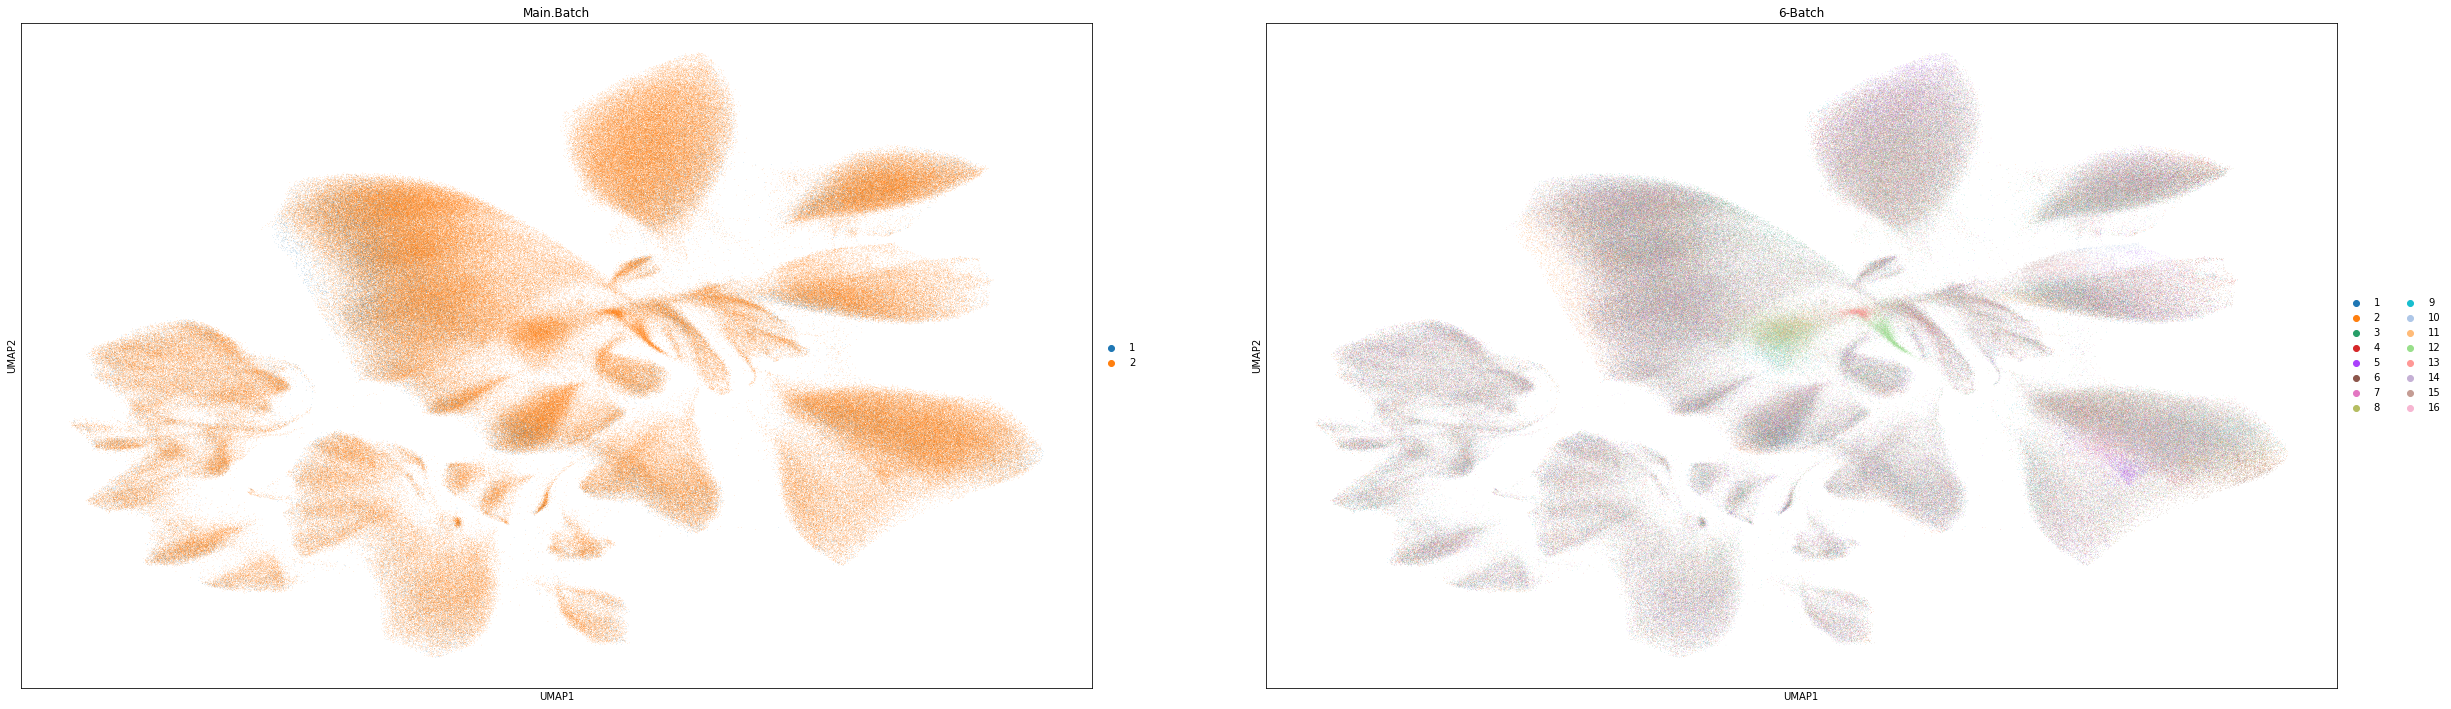

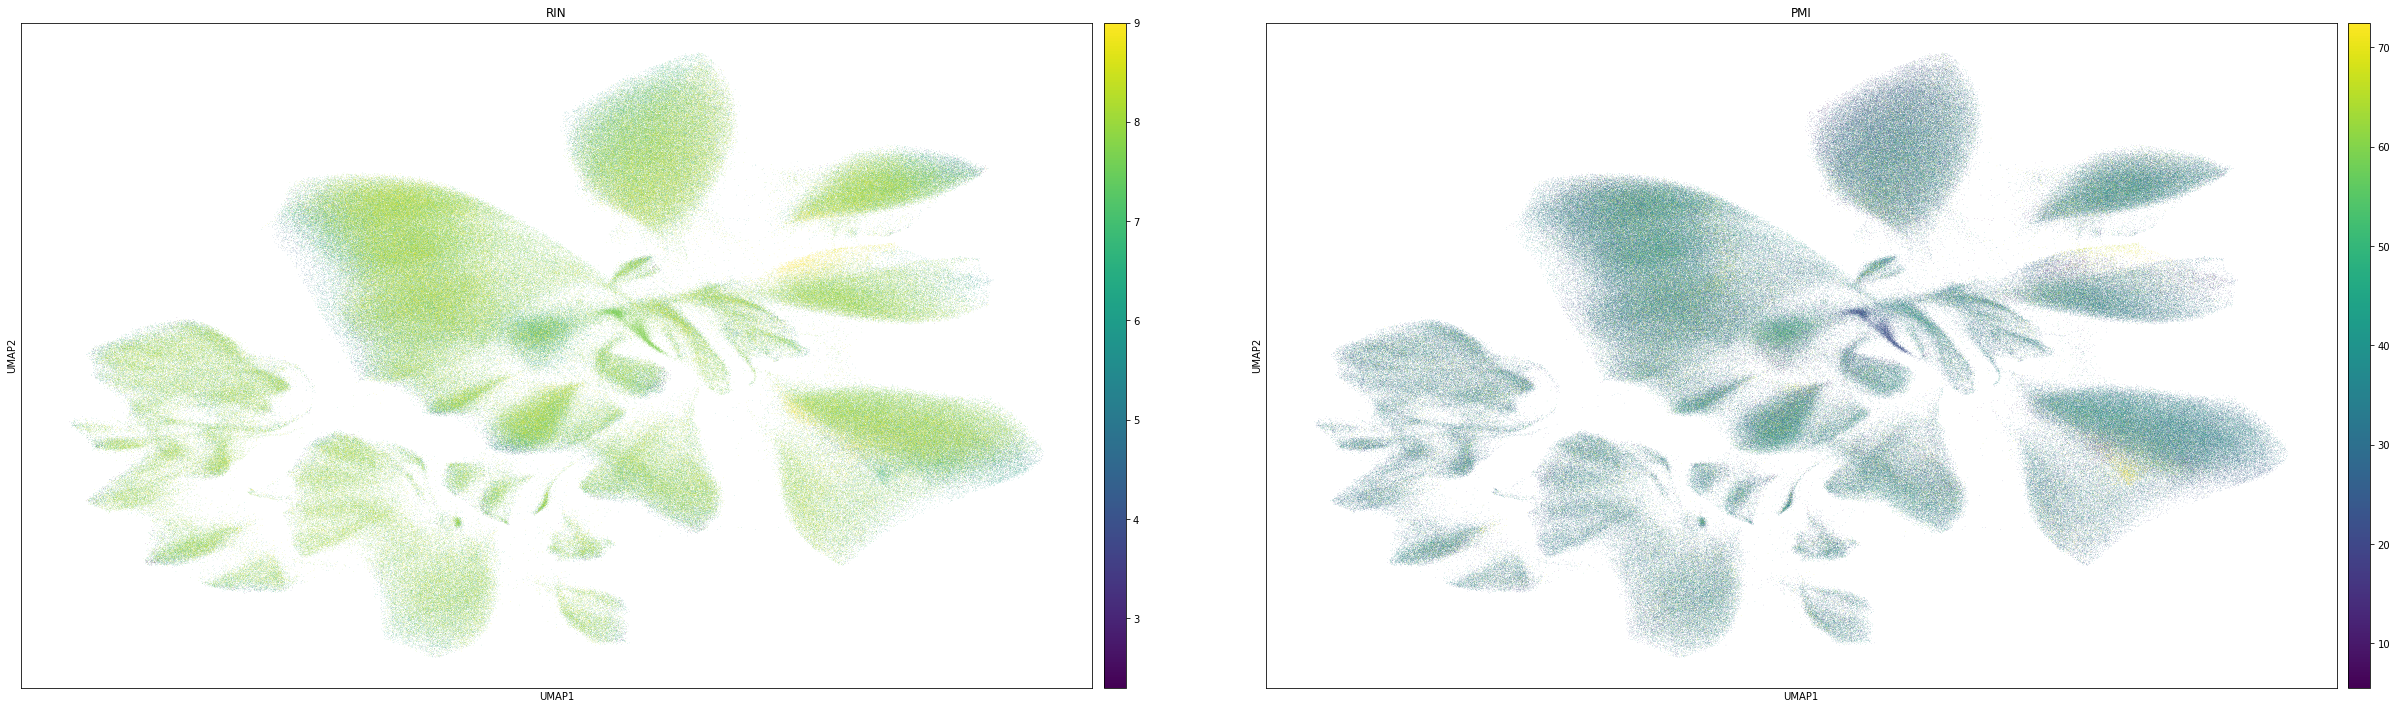

In [14]:
# Visualize the clustering and how this is reflected by different technical covariates with UMAP
sc.pl.umap(adata, color=['Main.Batch', '6-Batch'], size=500000 /adata.n_obs)#, palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['RIN', 'PMI'], size=500000 /adata.n_obs)
#sc.pl.umap(adata, color=['pct_counts_mito'])

## 1.4 Sample distribution per cluster

This analysis is made to analyse if a cluster is driven/contains only cells of one/few samples or if the distribution of samples per cluster is homogeneous.

In [ ]:
sc.pl.umap(adata, color=['leiden_r0.8'], size=500000 /adata.n_obs, legend_loc = 'on data')#, palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['sample'], size=500000 /adata.n_obs)#, palette=sc.pl.palettes.default_64)
sc.pl.umap(adata, color=['6-Batch'], size=500000 /adata.n_obs)#, palette=sc.pl.palettes.default_64)

## 1.5 Cluster distribution per sample

This analysis is made to analyse if a sample is only in one/few clusters.

### 1.5.1 Distribution per Sample

In [29]:
cm = sc.metrics.confusion_matrix('sample','leiden_r0.8', adata.obs)

In [ ]:
plt.rcParams['figure.figsize']=(25,12)
plt.figure()
sb.heatmap(cm.T, cmap="YlGnBu", linewidths=.5, vmin=0, vmax=1)

In [ ]:
# print and save matrix
cm.to_csv(p['basedir'] + 'tables/distrClustersPerSample_RNA_postFiltering.txt', index=True, header=True, sep=' ')
cm

### 1.5.2 Distribution per Cluster

In [32]:
cm = sc.metrics.confusion_matrix('leiden_r0.8', 'sample', adata.obs)

In [ ]:
plt.rcParams['figure.figsize']=(25,12)
plt.figure()
sb.heatmap(cm, cmap="YlGnBu", linewidths=.5, vmin=0, vmax=0.3)

In [ ]:
# print and save matrix
cm.to_csv(p['basedir'] + 'tables/distrSamplesPerCluster_RNA_postFiltering.txt', index=True, header=True, sep=' ')
cm

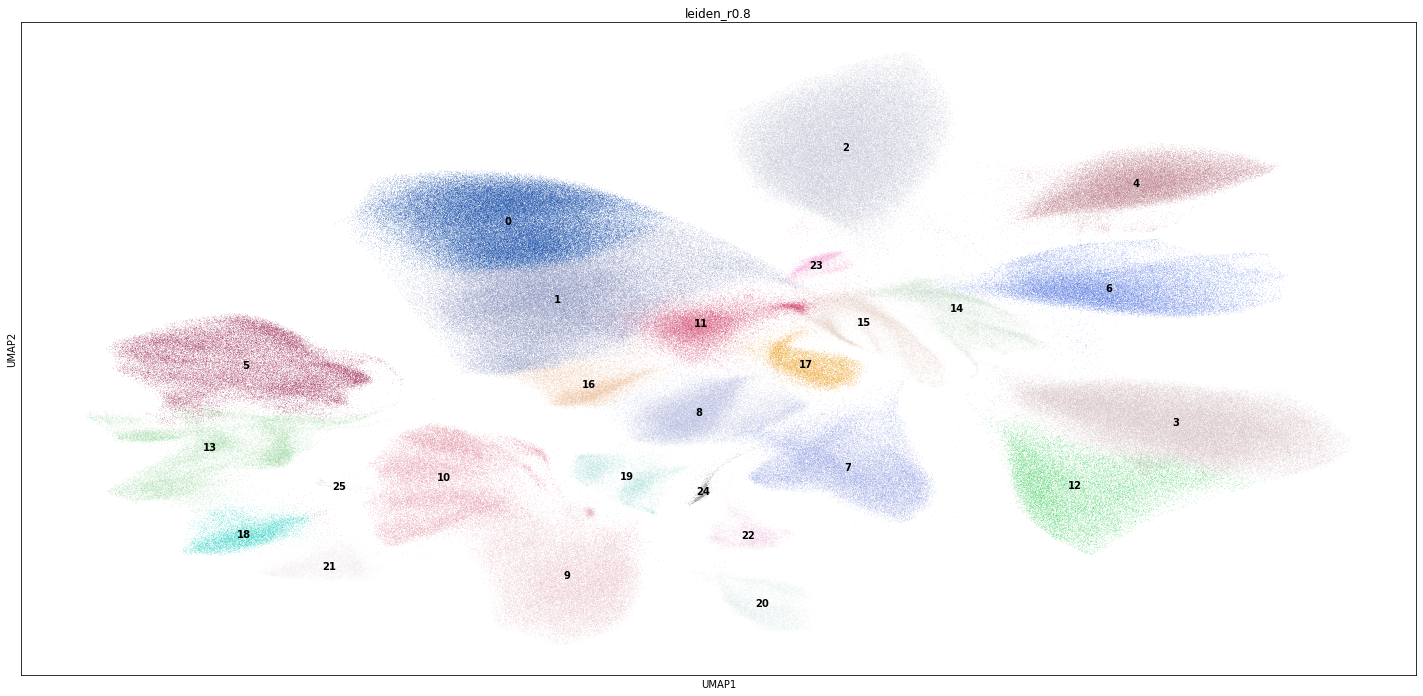

In [22]:
sc.pl.umap(adata, color=['leiden_r0.8'], size=500000 /adata.n_obs, legend_loc = 'on data')#, palette=sc.pl.palettes.default_64)